# 3. Cross-Venue Execution Comparison

This notebook compares execution quality between:
- **UniswapV4 DEX**: ETH/MORPHO pool on Ethereum
- **CEXs**: MORPHO/USDT trading pair on Bitget, Binance, and BitMart

Goals:
1. Identify which CEX has the deepest liquidity for MORPHO
2. Calculate slippage for $5K, $10K, $50K, $100K trades on CEX
3. Compare V4 vs CEX execution quality
4. Explain when each venue is superior

## 3.1 Which CEX Has the Deepest Liquidity?

### Web search

To identify the CEX with the deepest liquidity for MORPHO, we consulted [CoinGecko](https://www.coingecko.com/en/coins/morpho) which aggregates trading data across exchanges.

MORPHO tokens can be traded on centralized crypto exchanges. The most popular exchange to buy and trade Morpho is BitMart, where the most active trading pair MORPHO/USDT has a trading volume of **$1,607,126 in the last 24 hours**. Other popular options include **Bitget with $1,408,745 in the last 24 hours** and **Binance with $1,143,854 in the last 24 hours**.

### Systematic approach

This selection could be automated by:
1. Loop over exchange's orderbook
2. Calculating depth within $\varepsilon\%$ of mid price for each
3. Selecting the exchange with maximum $D_\varepsilon$

We demonstrate this analysis for **Bitget**, **Binance**, and **BitMart**.

#### **Orderbook Depth Within $\varepsilon$%**

CEX liquidity is represented as discrete limit orders in an **orderbook**: a list of $(p_i, q_i)$ pairs on bid and ask sides.

**Key metric**: Depth within $\varepsilon\%$ of mid price, denoted $D_\varepsilon$.

The **midprice** is

$$
P_{\text{mid}} = \frac{P_{\text{best,bid}} + P_{\text{best,ask}}}{2}.
$$

The **best bid** (*buy* MORPHO) is the *highest* buy price in the orderbook.
The **best ask** (*sell* MORPHO) is the *lowest* sell price in the orderbook.

A market **buy** of MORPHO consumes **asks** (sell orders).  
Depth within ε% is:
$$
D_{\varepsilon}^{\text{ask}}
=
\sum_{p_i \le (1+\varepsilon) P_{\text{mid}}} p_i q_i.
$$

A market **sell** of MORPHO consumes **bids** (buy orders).  
Depth within ε% is:
$$
D_{\varepsilon}^{\text{bid}}
=
\sum_{p_i \ge (1-\varepsilon) P_{\text{mid}}} p_i q_i.
$$

where $(p_i, q_i)$ are the price and quantity of each ask order.

**We will look at ask depth**

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from web3 import Web3
from dotenv import load_dotenv
import requests

# Add parent directory to path for imports
sys.path.append("..")

# Import CEX analysis module
from src.cex_analysis import (
    create_exchange, fetch_orderbook, batch_slippage_analysis, 
    compare_venues, get_orderbook_depth_summary
)

# Import V4 slippage calculation (same as Q1)
from src.config import (
    STATE_VIEW, QUOTER, ETH, MORPHO, POOL_ID_BYTES,
    FEE, TICK_SPACING, HOOKS
)
from src.abis import STATEVIEW_ABI, QUOTER_ABI
from src.slippage import calculate_slippage

In [2]:
# Initialize Bitget exchange
bitget = create_exchange('bitget')
print(f"Exchange: {bitget.id}")
print(f"Has orderbook: {bitget.has['fetchOrderBook']}")

Exchange: bitget
Has orderbook: True


In [3]:
# Connect to Ethereum RPC for V4 slippage calculation
load_dotenv()
url = os.getenv('rpc_url_mainnet')
w3 = Web3(Web3.HTTPProvider(url))
print(f"Connected to Ethereum: {w3.is_connected()}")

# Convert addresses to checksum format
QUOTER_CS = Web3.to_checksum_address(QUOTER)
STATE_VIEW_CS = Web3.to_checksum_address(STATE_VIEW)
ETH_CS = Web3.to_checksum_address(ETH)
MORPHO_CS = Web3.to_checksum_address(MORPHO)
HOOKS_CS = Web3.to_checksum_address(HOOKS)

# Fetch current ETH price for USD conversion
eth_resp = requests.get("https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd")
eth_price_usd = eth_resp.json().get("ethereum", {}).get("usd", 0)
print(f"Current ETH price: ${eth_price_usd:,.2f}")

Connected to Ethereum: True
Current ETH price: $3,086.82


In [4]:
# Fetch Bitget MORPHO/USDT orderbook
symbol = "MORPHO/USDT"
orderbook = fetch_orderbook(bitget, symbol, limit=500)
print(f"Exchange: {orderbook.exchange}, Symbol: {orderbook.symbol}")

# Calculate depth statistics at multiple percentage levels
depth_stats = get_orderbook_depth_summary(orderbook)

print("========== Bitget Orderbook Depth Analysis ==========")
print(f"\nMid Price: ${depth_stats['mid_price']:.4f}")
print(f"Spread: {depth_stats['spread_bps']:.2f} bps\n")

print(f"{'Level':<10} {'Bid Depth':<15} {'Ask Depth':<15}")
print("-" * 40)
for pct in [1, 2, 5]:
    bid_d = depth_stats[f'bid_depth_{pct}pct_usd']
    ask_d = depth_stats[f'ask_depth_{pct}pct_usd']
    print(f"D_{pct}%{'':<6} ${bid_d:>12,.0f}  ${ask_d:>12,.0f}")

print("\nTotal orderbook depth:")
print(f"  Bid side: ${depth_stats['total_bid_depth_usd']:,.2f}")
print(f"  Ask side: ${depth_stats['total_ask_depth_usd']:,.2f}")

Exchange: bitget, Symbol: MORPHO/USDT
========== Bitget Orderbook Depth Analysis ==========

Mid Price: $1.2228
Spread: 2.45 bps

Level      Bid Depth       Ask Depth      
----------------------------------------
D_1%       $     118,657  $     133,483
D_2%       $     130,734  $     138,619
D_5%       $     136,077  $     142,841

Total orderbook depth:
  Bid side: $150,585.70
  Ask side: $150,220.90


In [5]:
# Fetch Binance MORPHO/USDT orderbook for comparison
binance = create_exchange('binance')
print(f"Exchange: {binance.id}")
print(f"Has orderbook: {binance.has['fetchOrderBook']}\n")

orderbook_binance = fetch_orderbook(binance, symbol, limit=500)
print(f"Exchange: {orderbook_binance.exchange}, Symbol: {orderbook_binance.symbol}")

# Calculate depth statistics at multiple percentage levels
depth_stats_binance = get_orderbook_depth_summary(orderbook_binance)

print("========== Binance Orderbook Depth Analysis ==========")
print(f"\nMid Price: ${depth_stats_binance['mid_price']:.4f}")
print(f"Spread: {depth_stats_binance['spread_bps']:.2f} bps\n")

print(f"{'Level':<10} {'Bid Depth':<15} {'Ask Depth':<15}")
print("-" * 40)
for pct in [1, 2, 5]:
    bid_d = depth_stats_binance[f'bid_depth_{pct}pct_usd']
    ask_d = depth_stats_binance[f'ask_depth_{pct}pct_usd']
    print(f"D_{pct}%{'':<6} ${bid_d:>12,.0f}  ${ask_d:>12,.0f}")

print("\nTotal orderbook depth:")
print(f"  Bid side: ${depth_stats_binance['total_bid_depth_usd']:,.2f}")
print(f"  Ask side: ${depth_stats_binance['total_ask_depth_usd']:,.2f}")

Exchange: binance
Has orderbook: True

Exchange: binance, Symbol: MORPHO/USDT
========== Binance Orderbook Depth Analysis ==========

Mid Price: $1.2225
Spread: 8.18 bps

Level      Bid Depth       Ask Depth      
----------------------------------------
D_1%       $     268,252  $     277,444
D_2%       $     277,737  $     286,156
D_5%       $     286,750  $     287,819

Total orderbook depth:
  Bid side: $345,073.67
  Ask side: $584,882.33


In [6]:
# Fetch BitMart MORPHO/USDT orderbook for comparison
bitmart = create_exchange('bitmart')
print(f"Exchange: {bitmart.id}")
print(f"Has orderbook: {bitmart.has['fetchOrderBook']}\n")

orderbook_bitmart = fetch_orderbook(bitmart, symbol, limit=500)
print(f"Exchange: {orderbook_bitmart.exchange}, Symbol: {orderbook_bitmart.symbol}")

# Calculate depth statistics at multiple percentage levels
depth_stats_bitmart = get_orderbook_depth_summary(orderbook_bitmart)

print("========== BitMart Orderbook Depth Analysis ==========")
print(f"\nMid Price: ${depth_stats_bitmart['mid_price']:.4f}")
print(f"Spread: {depth_stats_bitmart['spread_bps']:.2f} bps\n")

print(f"{'Level':<10} {'Bid Depth':<15} {'Ask Depth':<15}")
print("-" * 40)
for pct in [1, 2, 5]:
    bid_d = depth_stats_bitmart[f'bid_depth_{pct}pct_usd']
    ask_d = depth_stats_bitmart[f'ask_depth_{pct}pct_usd']
    print(f"D_{pct}%{'':<6} ${bid_d:>12,.0f}  ${ask_d:>12,.0f}")

print("\nTotal orderbook depth:")
print(f"  Bid side: ${depth_stats_bitmart['total_bid_depth_usd']:,.2f}")
print(f"  Ask side: ${depth_stats_bitmart['total_ask_depth_usd']:,.2f}")

Exchange: bitmart
Has orderbook: True

Exchange: bitmart, Symbol: MORPHO/USDT
========== BitMart Orderbook Depth Analysis ==========

Mid Price: $1.2226
Spread: 8.18 bps

Level      Bid Depth       Ask Depth      
----------------------------------------
D_1%       $      64,192  $      73,777
D_2%       $     110,660  $     107,579
D_5%       $     112,500  $     109,162

Total orderbook depth:
  Bid side: $113,814.19
  Ask side: $146,485.73


## Comment on Result

Above we show how to calculate the orderbook depth for the MORPHO/USDT orderbook on Bitget, Binance, and BitMart. By comparing $D_\varepsilon$ across exchanges, we can identify which has the deepest liquidity.

**The deepest liquidity, using $D_\varepsilon$ as a proxy, has Binance**

However, orderbook depth is only a *static snapshot* of posted quotes. It does not represent the actual liquidity you will receive when trading. In practice, depth can be misleading for several reasons.

## 3.2 CEX Slippage Calculation

For a market buy of ${Q_\$}$ USD/USDT, assuming 1 to 1 relation, notional, we walk through the ask side of the orderbook and calculate:

$$P_{\text{mid}} = \frac{P_{\text{best,bid}} + P_{\text{best,ask}}}{2}$$

$$P_{\text{exec}} = \frac{Q_\$}{Q_{\text{base}}}$$

where $Q_{\text{base}}$ is the total base asset (MORPHO) acquired.

$$\text{Slippage} = \frac{P_{\text{exec}} - P_{\text{mid}}}{P_{\text{mid}}} \times 100\%$$

In [7]:
# Calculate slippage for standard trade sizes on all three CEXs
trade_sizes_usd = [5000, 10000, 50000, 100000]

# Buy orders (buying MORPHO with USDT) for each exchange
cex_results_bitget = batch_slippage_analysis(bitget, symbol, trade_sizes_usd, is_buy=True)
cex_results_binance = batch_slippage_analysis(binance, symbol, trade_sizes_usd, is_buy=True)
cex_results_bitmart = batch_slippage_analysis(bitmart, symbol, trade_sizes_usd, is_buy=True)

def print_slippage_results(results: list, exchange_name: str):
    print(f"========== {exchange_name} Slippage Results (BUY MORPHO) ==========")
    print(f"\n{'Trade Size':<12} {'Mid Price':<12} {'Avg Exec':<12} {'Slippage %':<12} {'Levels':<8} {'Filled?'}")
    print("-" * 70)
    for result in results:
        print(f"${result.trade_size_usd:>10,.0f} ${result.mid_price:<11.4f} ${result.avg_execution_price:<11.4f} {result.slippage_percentage:<11.4f}% {result.levels_consumed:<7} {'Yes' if result.fully_filled else 'No'}")
    print()

print_slippage_results(cex_results_bitget, "Bitget")
print_slippage_results(cex_results_binance, "Binance")
print_slippage_results(cex_results_bitmart, "BitMart")

========== Bitget Slippage Results (BUY MORPHO) ==========

Trade Size   Mid Price    Avg Exec     Slippage %   Levels   Filled?
----------------------------------------------------------------------
$     5,000 $1.2233      $1.2244      0.0879     % 17      Yes
$    10,000 $1.2233      $1.2252      0.1543     % 24      Yes
$    50,000 $1.2233      $1.2274      0.3366     % 38      Yes
$   100,000 $1.2233      $1.2292      0.4855     % 61      Yes

========== Binance Slippage Results (BUY MORPHO) ==========

Trade Size   Mid Price    Avg Exec     Slippage %   Levels   Filled?
----------------------------------------------------------------------
$     5,000 $1.2235      $1.2250      0.1187     % 2       Yes
$    10,000 $1.2235      $1.2253      0.1456     % 3       Yes
$    50,000 $1.2235      $1.2271      0.2951     % 5       Yes
$   100,000 $1.2235      $1.2276      0.3314     % 5       Yes

========== BitMart Slippage Results (BUY MORPHO) ==========

Trade Size   Mid Price    Avg Ex

In [8]:
# Calculate V4 slippage for the same trade sizes (USD -> ETH -> wei)
# Note: USDT treated as 1:1 with USD
v4_results = []

for usd_amount in trade_sizes_usd:
    # Convert USD to ETH amount
    eth_amount = usd_amount / eth_price_usd
    amount_in_wei = int(eth_amount * 10**18)
    
    result = calculate_slippage(
        w3=w3,
        amount_in_wei=amount_in_wei,
        stateview_address=STATE_VIEW_CS,
        stateview_abi=STATEVIEW_ABI,
        quoter_address=QUOTER_CS,
        quoter_abi=QUOTER_ABI,
        pool_id=POOL_ID_BYTES,
        currency0=ETH_CS,
        currency1=MORPHO_CS,
        fee=FEE,
        tick_spacing=TICK_SPACING,
        hooks=HOOKS_CS,
        zero_for_one=True
    )
    result["usd_amount"] = usd_amount
    v4_results.append(result)

print("========== V4 DEX Slippage Results (BUY MORPHO) ==========")
print(f"\n{'Trade Size':<12} {'Slippage %':<12}")
print("-" * 30)
for r in v4_results:
    print(f"${r['usd_amount']:>10,} {r['slippage_percentage']:.4f}%")

========== V4 DEX Slippage Results (BUY MORPHO) ==========

Trade Size   Slippage %  
------------------------------
$     5,000 0.4908%
$    10,000 0.6810%
$    50,000 1.9544%
$   100,000 2.7459%


## 3.3 Comparing V4 and CEX

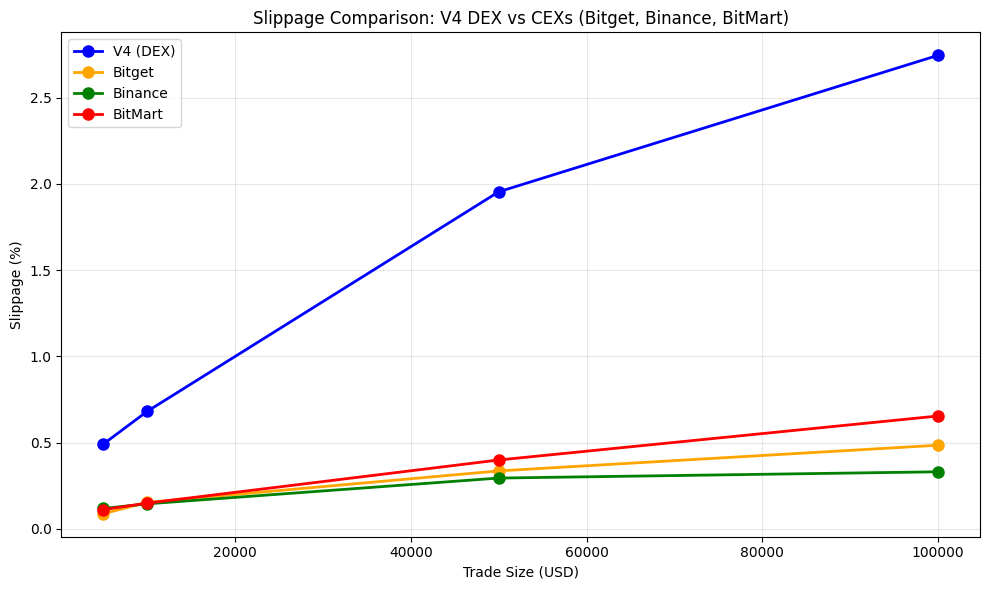

In [9]:
# Extract slippages from computed results
v4_slippages = [r["slippage_percentage"] for r in v4_results]
bitget_slippages = [r.slippage_percentage for r in cex_results_bitget]
binance_slippages = [r.slippage_percentage for r in cex_results_binance]
bitmart_slippages = [r.slippage_percentage for r in cex_results_bitmart]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(trade_sizes_usd, v4_slippages, 'o-', color='blue', linewidth=2, markersize=8, label='V4 (DEX)')
ax.plot(trade_sizes_usd, bitget_slippages, 'o-', color='orange', linewidth=2, markersize=8, label='Bitget')
ax.plot(trade_sizes_usd, binance_slippages, 'o-', color='green', linewidth=2, markersize=8, label='Binance')
ax.plot(trade_sizes_usd, bitmart_slippages, 'o-', color='red', linewidth=2, markersize=8, label='BitMart')

ax.set_xlabel('Trade Size (USD)')
ax.set_ylabel('Slippage (%)')
ax.set_title('Slippage Comparison: V4 DEX vs CEXs (Bitget, Binance, BitMart)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/slippage_comparison_CEX_vs_DEX.png", bbox_inches="tight")
plt.show()

## Roughly estimating costs

In [10]:
# Compare total execution cost: slippage + fees + gas
# Using Binance (deepest liquidity) for the comparison

# V4 pool fee from config (FEE is in hundredths of bps, so 2999 = 29.99 bps)
v4_fee_bps = FEE / 100  # 29.99 bps

# Fetch CEX trading fees from exchange (taker fee for market orders)
binance.load_markets()
market_info = binance.market(symbol)
cex_fee_bps = market_info['taker'] * 10000  # Convert from decimal (0.001) to bps (10)
print(f"Binance taker fee: {cex_fee_bps:.2f} bps ({market_info['taker']*100:.2f}%)")

# Estimate gas cost based on current gas price
# V4 swap typically uses ~150k gas
gas_price_wei = w3.eth.gas_price
gas_used = 150_000  # Estimated gas for V4 swap
gas_cost_eth = (gas_price_wei * gas_used) / 10**18
gas_cost_usd = gas_cost_eth * eth_price_usd
print(f"Estimated gas cost: {gas_cost_eth:.6f} ETH (${gas_cost_usd:.2f} at ${eth_price_usd:.0f}/ETH)")
print(f"V4 pool fee: {v4_fee_bps:.2f} bps ({v4_fee_bps/100:.4f}%)\n")

comparisons = compare_venues(
    v4_results=v4_results,
    cex_results=cex_results_binance,
    v4_fee_bps=v4_fee_bps,
    cex_fee_bps=cex_fee_bps,
    gas_cost_usd=gas_cost_usd
)

print("========== Total Execution Cost Comparison (V4 vs Binance) ==========")
print(f"\n{'Trade Size':<12}\t{'V4 Slip%':<10}\t{'CEX Slip%':<10}\t{'V4 Cost$':<12}\t{'CEX Cost$':<12}\t{'Winner'}")
print("-" * 90)
for c in comparisons:
    print(f"${c['trade_size_usd']:>10,.0f}\t{c['v4_slippage_pct']:<9.3f}\t{c['cex_slippage_pct']:<9.3f}\t${c['v4_total_cost_usd']:<10,.2f}\t${c['cex_total_cost_usd']:<10,.2f}\t{c['winner']}")

Binance taker fee: 10.00 bps (0.10%)
Estimated gas cost: 0.000059 ETH ($0.18 at $3087/ETH)
V4 pool fee: 29.99 bps (0.2999%)

========== Total Execution Cost Comparison (V4 vs Binance) ==========

Trade Size  	V4 Slip%  	CEX Slip% 	V4 Cost$    	CEX Cost$   	Winner
------------------------------------------------------------------------------------------
$     5,000	0.491    	0.119    	$39.72     	$10.93     	CEX
$    10,000	0.681    	0.146    	$98.27     	$24.56     	CEX
$    50,000	1.954    	0.295    	$1,127.32  	$197.54    	CEX
$   100,000	2.746    	0.331    	$3,045.99  	$431.43    	CEX


## 3.3 When Is Each Venue Superior?

The above results are somewhat counter-intuitive as one might assume there would be some cost benefit to using a DEX in terms of slippage. However, we see that slippage is actually larger on V4 and the total cost estimates favor the CEX across all trade sizes.

It's worth noting that the ETH/MORPHO pool on V4 is relatively shallow compared to the CEX orderbooks. This specific pool simply doesn't have deep liquidity, which explains much of the slippage difference. A more liquid V4 pool (e.g., ETH/USDC) would likely show different results.

Our CEX cost estimates are rough and do not include withdrawal fees. If you need to move tokens on-chain after trading (e.g., to use MORPHO in DeFi), you'd pay an additional ~$10-20 in withdrawal fees, which narrows the gap for smaller trades.

### Why does CEX win here?

For a token like MORPHO, this result makes sense. Professional market makers actively provide liquidity on Binance and Bitget, keeping spreads tight. The V4 pool has limited concentrated liquidity, so larger trades quickly push through the high-liquidity tick range into thinner regions where slippage compounds. CEX volume (~$1-2M daily across top exchanges) attracts more liquidity providers, creating a virtuous cycle. Speed and advanced order types (limits, stop-losses) are additional CEX advantages.

That said, V4 would likely win for tokens with thin CEX orderbooks, where long-tail assets often have better DEX liquidity than fragmented CEX listings. Composability is another factor — if you need to swap, deposit, and stake in one atomic transaction, on-chain execution wins. And trustlessness matters to some: no KYC, no custody risk, no withdrawal delays.